## 3D Cookbook with Seed1.5-VL

Understanding 3D space is a fundamental capability of human for perception and reasoning. The **Seed1.5-VL** offers accurate and versatile 3D understanding abilities.

For object localization, we primarily use two common representations: 

**3D bounding boxes**: We represent 3D bounding boxes in the format `<3dbbox>x y z x_size y_size z_size pitch yaw roll</3dbbox>`. The definition of the 3D bounding box is as follows.

(1) `x`, `y`, `z`: the center of the object in the camera coordinate, in meters. 

(2) `x_size`, `y_size`, `z_size`: The dimensions of the object along the XYZ axes, in meters, when the rotation angles are zero. 

(3) `pitch`, `yaw`, `roll`: Euler angles representing rotations around the X, Y, and Z axes, respectively. Each angle is normalized to the range of (-1, 1) and is multiplied by 180 to convert it into degrees. 

**Center points**: Similar with 2D tasks, we represent each coordinate in the image using `<point>x y</point>`. All coordinates are in a **relative format**, normalized to a range of `0–999`. Therefore, after obtaining the model outputs, we need to further scale the coordinates according to the image's width and height to obtain the absolute position coordinates.

Currently, Seed1.5-VL supports following capabilities:

* 3D Grounding
* Depth Estimation
* Object Sorting

In [ ]:
# Copyright (2025) [Seed-VL-Cookbook] Bytedance Seed 
import os
import re
import math
import base64
import requests

import cv2
import random
import numpy as np
from PIL import Image

### 0. Obtain the API Key
register and setup a service: https://www.volcengine.com/product/doubao

In [ ]:
# Please set the API key here
os.environ['OPENAI_API_KEY'] = #'YOUR API KEY'
seed_vl_version = "doubao-1-5-thinking-vision-pro-250428"
api_url = "https://ark.cn-beijing.volces.com/api/v3/chat/completions"

In [477]:
# encode image into base64 encoding
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        image = base64.b64encode(image_file.read()).decode('utf-8')
    return image

def inference_image(text_content, image_path, enable_thniking_mode='disabled'):
    headers = {
        'Authorization': f'Bearer {os.environ.get("OPENAI_API_KEY")}',
        'Content-Type': 'application/json'
    }
    base64_image = encode_image(image_path)
    image_format = image_path.split('.')[-1]
    assert image_format in ['jpg', 'jpeg', 'png', 'webp']
    data = {
        "model": seed_vl_version,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": text_content
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/{image_format};base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "thinking": {"type": enable_thniking_mode}
    }
    
    response = requests.post(api_url, headers=headers, json=data)
    
    if response.status_code == 200:
        return response.json()["choices"][0]
    else:
        return {
            "error": f"Request failed with status code {response.status_code}",
            "details": response.text
        }

### 1. 3D Grounding
Localizing specific 3D objects in an image based on a natural language phrase or a 3D object category is supported by Seed1.5-VL.
Here, we provide a simple demo to show how to use Seed1.5-VL for 3D grounding.

Because accurate 3D perception highly rely on camera params, please make sure you have camera intrinsic params (focal length `fx`,`fy` and principal point `cx`,`cy`) for better experience. If you don't have camera params, we will generate a group of general camera params with `fov=60°` for you to try this demo.


In [478]:
image_path = "samples/demo_3d_image.jpg"
text_prompts = "Here are the detailed camera parameters for the image. Camera intrinsic parameters: Focal length f_x={fx}, f_y={fy}. Principal point coordinate locates near the center of the image, c_x={cx} and c_y={cy}, when image width {w} and height {h}. We do not consider distortion parameters here. Therefore, the intrinsic matrix K = [[{fx}, 0, {cx}], [0, {fy}, {cy}], [0, 0, 1]]. Camera coordinate: X-axis points rightward, Y-axis points downward, and Z-axis points forward. The origin point is the camera location. We take the camera coordinate system as the world coordinate system, namely the camera extrinsic matrix is [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]]. Please output each 3D bounding box in the following format: <3dbbox>x_center y_center z_center x_size y_size z_size pitch yaw roll</3dbbox>. Note: (1) x_center, y_center, z_center: the center of the object in the camera coordinate, in meters. (2) x_size, y_size, z_size: The dimensions of the object along the XYZ axes, in meters, when the rotation angles are zero. (3) pitch, yaw, roll: Euler angles representing rotations around the X, Y, and Z axes, respectively. Each angle is normalized to the range of (-1, 1) and is multiplied by 180 to convert it into degrees."
question = "Detect the cup in this image and display the results in the form of 3D bounding boxes."

In [479]:
def generate_camwise_prompts(prompt, image_path, fx=None, fy=None, cx=None, cy=None, fov=60):
    image = Image.open(image_path)
    w, h = image.size
    # generate pseudo camera params if not provided
    if fx is None or fy is None:
        fx = round(w / (2 * np.tan(np.deg2rad(fov) / 2)), 2)
        fy = round(h / (2 * np.tan(np.deg2rad(fov) / 2)), 2)
    if cx is None or cy is None:
        cx = round(w / 2, 2)
        cy = round(h / 2, 2)

    camwise_prompts = prompt.format(cx=cx, cy=cy, fx=fx, fy=fy, w=w, h=h)
    cam_params = {'cx':cx, 'cy':cy, 'fx':fx, 'fy':fy}
    return camwise_prompts, cam_params

In [480]:
# We set fx fy cx cy here for demonstration purpose
# If you have camere parms: replace fx fy cx cy with your own values
# If you don't have camere parms: replace fx fy cx cy with None
question_prompts = f"{text_prompts} {question}"
camwise_prompts, cam_params = generate_camwise_prompts(question_prompts, image_path, fx=866.27, fy=866.27, cx=512.00, cy=384.00)
result = inference_image(camwise_prompts, image_path)
print("Seed1.5-VL:", result["message"]["content"])

Seed1.5-VL: <3dbbox>0.43 -0.12 1.60 0.12 0.23 0.18 -0.99 0.21 0.01</3dbbox>


In [481]:
def convert_3dbbox(point, cam_params):
    x, y, z, x_size, y_size, z_size, pitch, yaw, roll = point
    hx, hy, hz = x_size / 2, y_size / 2, z_size / 2
    local_corners = [
        [ hx,  hy,  hz],
        [ hx,  hy, -hz],
        [ hx, -hy,  hz],
        [ hx, -hy, -hz],
        [-hx,  hy,  hz],
        [-hx,  hy, -hz],
        [-hx, -hy,  hz],
        [-hx, -hy, -hz]
    ]

    def rotate_xyz(_point, _pitch, _yaw, _roll):
        x0, y0, z0 = _point
        x1 = x0
        y1 = y0 * math.cos(_pitch) - z0 * math.sin(_pitch)
        z1 = y0 * math.sin(_pitch) + z0 * math.cos(_pitch)

        x2 = x1 * math.cos(_yaw) + z1 * math.sin(_yaw)
        y2 = y1
        z2 = -x1 * math.sin(_yaw) + z1 * math.cos(_yaw)

        x3 = x2 * math.cos(_roll) - y2 * math.sin(_roll)
        y3 = x2 * math.sin(_roll) + y2 * math.cos(_roll)
        z3 = z2

        return [x3, y3, z3]
    
    img_corners = []
    for corner in local_corners:
        rotated = rotate_xyz(corner, np.deg2rad(pitch), np.deg2rad(yaw), np.deg2rad(roll))
        X, Y, Z = rotated[0] + x, rotated[1] + y, rotated[2] + z
        if Z > 0:
            x_2d = cam_params['fx'] * (X / Z) + cam_params['cx']
            y_2d = cam_params['fy'] * (Y / Z) + cam_params['cy']
            img_corners.append([x_2d, y_2d])

    

    return img_corners

def draw_3dbboxes(image_path, cam_params, message):
    pattern = r'<3dbbox>([\d\.\s\-]+)</3dbbox>'
    matches = re.findall(pattern, message)
    answers = []
    for match in matches:
        _answer = list(map(float, match.split()))
        if len(_answer) != 9:
            continue
        # convert nomalized degree to (-180, 180)
        _answer[-3:] = [_x * 180 for _x in _answer[-3:]]
        answers.append(_answer)

    annotated_image = cv2.imread(image_path)
    edges = [
            [0,1], [2,3], [4,5], [6,7],
            [0,2], [1,3], [4,6], [5,7],
            [0,4], [1,5], [2,6], [3,7]
        ]
    for bbox_3d in answers:
        bbox_2d = convert_3dbbox(bbox_3d, cam_params)
        color = [random.randint(0, 255) for _ in range(3)]
        for start, end in edges:
            pt1 = tuple([int(_pt) for _pt in bbox_2d[start]])
            pt2 = tuple([int(_pt) for _pt in bbox_2d[end]])
            cv2.line(annotated_image, pt1, pt2, color, 2)
    return annotated_image

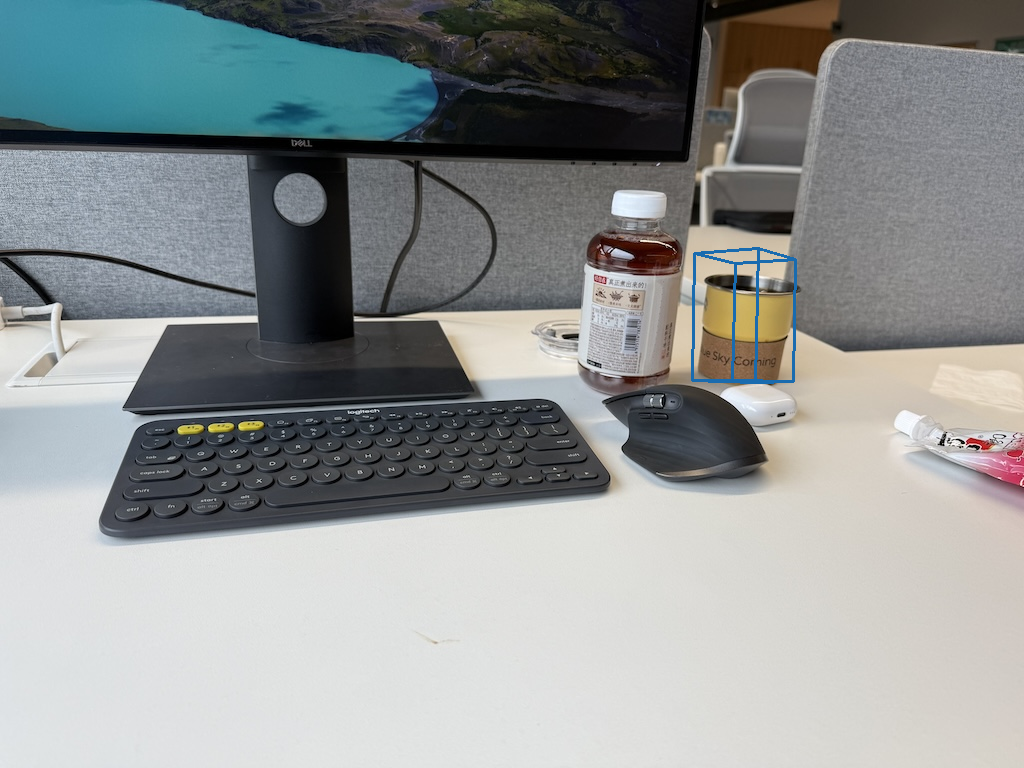

In [482]:
annotated_image = draw_3dbboxes(image_path, cam_params, result["message"]["content"])
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
Image.fromarray(annotated_image)

### 2. Depth Estimation

Seed1.5-VL supports depth estimation, which is a crucial component in many applications such as 3D reconstruction, virtual reality, and augmented reality. You can use the following code to estimate the depth of objects with input point coordinates or just visualized points.

Similar to 3D grounding, accurate depth estimation highly rely on camera params, please make sure you have camera intrinsic params (focal length `fx`,`fy` and principal point `cx`,`cy`) for better experience. If you don't have camera params, we will generate a group of general camera params with `fov=60°` for you to try this demo.

In [483]:
text_prompts = "Here are the detailed camera parameters for the image. Camera intrinsic parameters: Focal length f_x={fx}, f_y={fy}. Principal point coordinate locates at the center of the image, c_x={cx} and c_y={cy}, when image width {w} and height {h}. We do not consider distortion parameters here. Therefore, the intrinsic matrix K = [[{fx}, 0, {cx}], [0, {fy}, {cy}], [0, 0, 1]]. Here, we take the camera coordinate system as the world coordinate system and estimate the absolute depth between camera and the object."
question = "Estimate the absolute distance between the photographer and the object in {}. Respond directly with the absolute distance in meters only."

Predict with points `<point>x y</point>`

In [484]:
# We set fx fy cx cy here for demonstration purpose
# If you have camere parms: replace fx fy cx cy with your own values
# If you don't have camere parms: replace fx fy cx cy with None
image_path = "samples/demo_3d_image.jpg"
obj_coords = "<point>723 417</point>"
question_prompts = f"{text_prompts} {question.format(obj_coords)}"
camwise_prompts, cam_params = generate_camwise_prompts(question_prompts, image_path, fx=866.27, fy=866.27, cx=512.00, cy=384.00)
result = inference_image(camwise_prompts, image_path)
print("Seed1.5-VL:", result["message"]["content"])


Seed1.5-VL: 1.08 meters


In [485]:
def draw_depth(image_path, coords, message):
    annotated_image = cv2.imread(image_path)
    h, w = annotated_image.shape[:2]
    img_coords = re.search(r"<point>(.*?)</point>", coords)
    img_coords = [float(_coord) for _coord in img_coords.group(1).split()]
    img_coords = (int(img_coords[0]/1000*w), int(img_coords[1]/1000*h))
    cv2.circle(annotated_image, img_coords, radius=5, color=(0, 0, 255), thickness=-1)
    cv2.putText(annotated_image, str(message), (img_coords[0] + 10, img_coords[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return annotated_image

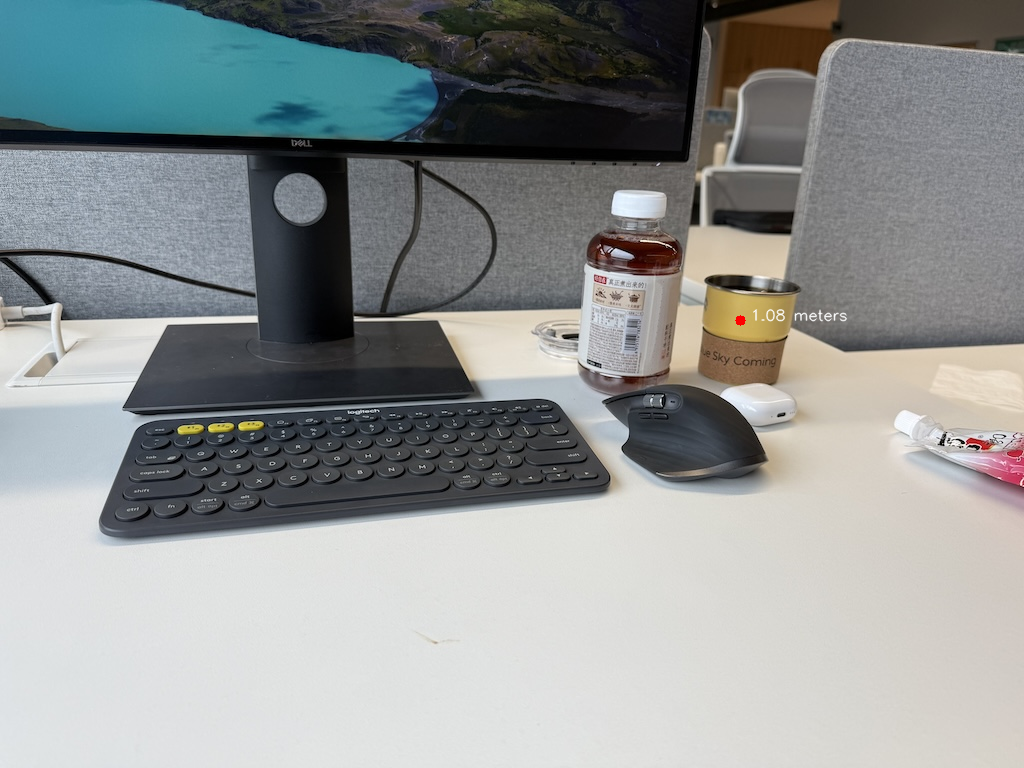

In [486]:
# Visualize the depth prediction
annotated_image = draw_depth(image_path, obj_coords, result["message"]["content"])
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
Image.fromarray(annotated_image)

Predict with visualized points

In [487]:
# We set fx fy cx cy here for demonstration purpose
# If you have camere parms: replace fx fy cx cy with your own values
# If you don't have camere parms: replace fx fy cx cy with None
image_path = "samples/demo_3d_image_with_pts.jpg"
obj_name = "red point"
question_prompts = f"{text_prompts} {question.format(obj_name)}"
camwise_prompts, cam_params = generate_camwise_prompts(question_prompts, image_path, fx=866.27, fy=866.27, cx=512.00, cy=384.00)
result = inference_image(camwise_prompts, image_path)
print("Seed1.5-VL:", result["message"]["content"])

Seed1.5-VL: 1.02 meters


### 3. Object Sorting
Seed1.5-VL also supports object sorting according to the depth of the objects. This capability is particularly useful when dealing with objects that are not easily distinguishable. You can use the following code to sort the objects from near to far with input object description or just visualized points.

Sort with object description

In [488]:
text_prompts = "Sort the headphone case, mouse, keyboard, water glass, and drink bottle in the picture according to the distance from me."

image_path = "samples/demo_3d_image.jpg"
result = inference_image(text_prompts, image_path)
print("Seed1.5-VL:", result["message"]["content"])

Seed1.5-VL: From closest to farthest, the order is as follows:

1. Keyboard
2. Mouse
3. Headphone case
4. Water glass
5. Drink bottle


Sort with visualized points

Seed1.5-VL: To determine the close to far order, we analyze the positions of the points:

1. Point2 (yellow) is on the keyboard, which is the closest object among the labeled points.
2. Point4 (red) is on the mouse, which is the next closest.
3. Point1 (blue) is on the small white device near the cup, which is further back.
4. Point3 (green) is on the cup, which is the farthest among the labeled points.

So the order from close to far is:

1. Keyboard (point2)
2. Mouse (point4)
3. Small white device (point1)
4. Cup (point3)


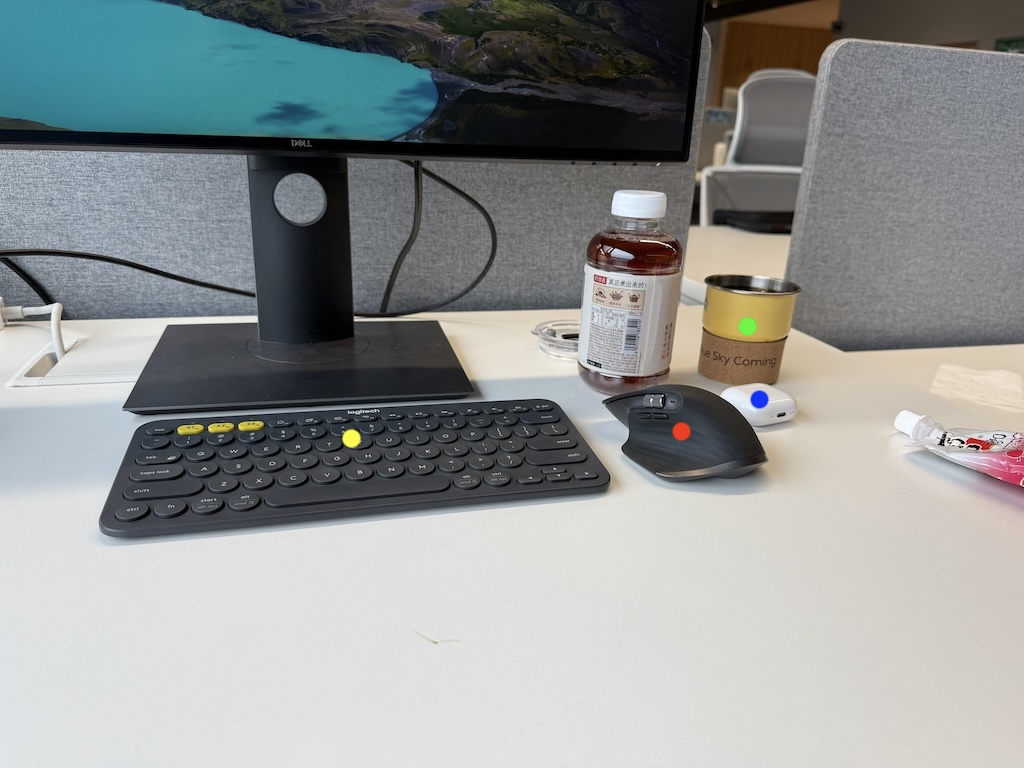

In [489]:
text_prompts = "There are several points with different colors in the image: {}. Each point represents an object. Please sort the object represented by these points in a close to far order and give their name."
objects = "point1: blue, point2: yellow, point3: green, point4: red"
question_prompts = text_prompts.format(objects)

image_path = "samples/demo_3d_image_with_multipts.jpg"
result = inference_image(question_prompts, image_path)
print("Seed1.5-VL:", result["message"]["content"])
Image.open(image_path)